# 01 - Non-ICU Hospital Admission Cohort Construction

## 0. Overview

This notebook constructs the base analytic cohort of non-ICU hospital admissions from the MIMIC-IV database.
The goal is to define a clean, admission-level cohort by excluding any hospital admissions associated with an ICU stay.

The resulting cohort serves as the foundational input for all downstream exposure definition, data integration, and outcome analysis notebooks.
This notebook focuses exclusively on constructing and validating the base adult hospital admissions table and does not define exposure or outcomes.

ICU admissions are excluded in a subsequent SQL-based preprocessing step (`02_exclude_icu_admissions.sql`).

## 1. Purpose

The purpose of this notebook is to create a well-defined non-ICU hospital admission cohort at the HADM level.

Specifically, this notebook:
- Excludes all hospital admissions with any recorded ICU stay
- Ensures one row per hospital admission (subject_id, hadm_id)
- Performs minimal demographic harmonization (race grouping) to ensure modeling stability
- Produces a stable cohort table for downstream exposure definition and outcome analyses
  
No exposure variables, outcome definitions, or statistical modeling are defined or estimated in this notebook.

## 2. Data Sources
- **MIMIC-IV v3.1** (BigQuery public dataset)
- Project: `mimic-iv-portfolio`

**Source tables (BigQuery public dataset):**
- `physionet-data.mimiciv_3_1_hosp.admissions`
- `physionet-data.mimiciv_3_1_hosp.patients`
- `physionet-data.mimiciv_3_1_icu.icustays`

**Derived datasets created in this notebook:**
- `mimic-iv-portfolio.nonicu_raas.base_admissions`<br>
  (created in 01 using `01_build_base_hosp_admissions.sql`)

- `mimic-iv-portfolio.nonicu_raas.base_admissions_racegrp`<br>
  (created in 01 using `01_collapse_race_categories.sql`)

- `mimic-iv-portfolio.nonicu_raas.nonicu_admissions`<br>
  (created in 01 using `02_exclude_icu_admissions.sql`)

## 3. Build Cohort and Exposure Tables in BigQuery
### 3.1 BigQuery Client Initialization and Helper Functions

In [1]:
# Use Application Default Credentials (my user account)
# This account already has PhysioNet BigQuery access.

from google.cloud import bigquery
from google.auth import default
import pandas as pd
from pathlib import Path

from google.cloud import bigquery
from google.auth import default
from pathlib import Path

# 1. Define project ID, dataset, and table references
PROJECT_ID = "mimic-iv-portfolio"
DATASET = "nonicu_raas"

TABLE_BASE=f"{PROJECT_ID}.{DATASET}.base_admissions"         # Created in 01_build_base_hosp+admissions.sql
TABLE_BASE_RACE = f"{PROJECT_ID}.{DATASET}.base_admissions_racegrp"  # Created in 01_collapse_race_categories.sql
TABLE_NONICU = f"{PROJECT_ID}.{DATASET}.nonicu_admissions"   # Created in 02_exclude_icu_admissions.sql


# 2. Get ADC credentials
creds, adc_project = default()

# 3. Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID, credentials=creds)

print("Connected to BigQuery project:", PROJECT_ID)
print("ADC default project:", adc_project)

# 4. Helper to run a SQL script file (DDL, CREATE TABLE, etc.)
def run_sql_script(path) :
    """
    Read a .sql file from disk, execute it in BigQuery,
    and wait until the job finishes.
    Use this for CREATE TABLE / INSERT INTO scripts.
    """
    sql_path = Path(path)
    with sql_path.open("r") as f:
        query = f.read()
    job = client.query(query)
    job.result()
    print(f"Executed SQL script: {sql_path.name}")

Connected to BigQuery project: mimic-iv-portfolio
ADC default project: mimic-iv-portfolio


### 3.2 Build Base Adult Hospital Admissions (One Row per Admission)

In [2]:
# Excecute SQL script (01_build_base_hosp_admissions.sql)
run_sql_script("../sql/01_build_base_hosp_admissions.sql")

Executed SQL script: 01_build_base_hosp_admissions.sql


At this stage, we construct a base adult hospital admissions table that serves as the foundation for all downstream cohort filtering and exposure definition steps.

This table ensures a one-to-one correspondence between rows and hospital admissions and provides standardized demographic and admission-level variables.

### 3.3 Load and Inspect Base Admissions Table

In [3]:
query_base = f"""
SELECT *
FROM `{TABLE_BASE}`
"""

df_base = client.query(query_base).to_dataframe()

df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            546028 non-null  Int64         
 1   hadm_id               546028 non-null  Int64         
 2   admittime             546028 non-null  datetime64[us]
 3   dischtime             546028 non-null  datetime64[us]
 4   deathtime             11790 non-null   datetime64[us]
 5   hospital_expire_flag  546028 non-null  Int64         
 6   admission_type        546028 non-null  object        
 7   admission_location    546027 non-null  object        
 8   discharge_location    396210 non-null  object        
 9   insurance             536673 non-null  object        
 10  language              545253 non-null  object        
 11  marital_status        532409 non-null  object        
 12  race                  546028 non-null  object        
 13 

### 3.4 Construction of Collapsed Race Categories

In [4]:
# Excecute SQL script (01_collapse_race_categories.sql)
run_sql_script("../sql/01_collapse_race_categories.sql")

Executed SQL script: 01_collapse_race_categories.sql


### 3.5 Validation of Collapsed Race Categories

In [5]:
query_base_race = f"""
SELECT *
FROM `{TABLE_BASE_RACE}`
"""

df_base_race = client.query(query_base_race).to_dataframe()

df_base_race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            546028 non-null  Int64         
 1   hadm_id               546028 non-null  Int64         
 2   admittime             546028 non-null  datetime64[us]
 3   dischtime             546028 non-null  datetime64[us]
 4   deathtime             11790 non-null   datetime64[us]
 5   hospital_expire_flag  546028 non-null  Int64         
 6   admission_type        546028 non-null  object        
 7   admission_location    546027 non-null  object        
 8   discharge_location    396210 non-null  object        
 9   insurance             536673 non-null  object        
 10  language              545253 non-null  object        
 11  marital_status        532409 non-null  object        
 12  race                  546028 non-null  object        
 13 

### 3.6 Exclude ICU Admissions to Define the Non-ICU Cohort

In [6]:
# Excecute SQL script (02_exclude_icu_admissions.sql)
run_sql_script("../sql/02_exclude_icu_admissions.sql")

Executed SQL script: 02_exclude_icu_admissions.sql



After excluding admissions with any ICU stay, we load the resulting
non-ICU admissions table from BigQuery and inspect its structure to
confirm row counts, variable availability, and data types.

### 3.7 Load and Inspect the Non-ICU Admissions Table

In [7]:
query_nonicu = f"""
SELECT *
FROM `{TABLE_NONICU}`
"""
df_nonicu = client.query(query_nonicu).to_dataframe()

df_nonicu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460786 entries, 0 to 460785
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            460786 non-null  Int64         
 1   hadm_id               460786 non-null  Int64         
 2   admittime             460786 non-null  datetime64[us]
 3   dischtime             460786 non-null  datetime64[us]
 4   deathtime             2324 non-null    datetime64[us]
 5   hospital_expire_flag  460786 non-null  Int64         
 6   admission_type        460786 non-null  object        
 7   admission_location    460785 non-null  object        
 8   discharge_location    311810 non-null  object        
 9   insurance             452862 non-null  object        
 10  language              460377 non-null  object        
 11  marital_status        454118 non-null  object        
 12  race                  460786 non-null  object        
 13 

## 4. Sanity Checks

### 4.1 Sanity Check: Non-ICU Cohort Proportion

In [8]:
print("Base adult admissions:", df_base.shape[0])
print("Non-ICU admissions:", df_nonicu.shape[0])

print(
    "Proportion non-ICU:",
    round(df_nonicu.shape[0] / df_base.shape[0], 3)
)

Base adult admissions: 546028
Non-ICU admissions: 460786
Proportion non-ICU: 0.844


**Descriptive Summary**

- The base adult hospital admission cohort consisted of 546,028 admissions.
- After excluding admissions with any ICU stay, 460,786 non-ICU admissions remained.
- Overall, 84.4% of adult hospital admissions in the base cohort did not involve an ICU stay and were included in the non-ICU analytic cohort.

### 4.2 Missingness Check for race_group

In [9]:
df_base_race["race_group"].isna().sum()

np.int64(0)

**Descriptive Summary**

- The race_group variable contained no missing values across the cohort (0 missing observations).

### 4.3 Distribution of Collapsed Race Categories

In [10]:
df_base_race["race_group"].value_counts()

race_group
White       360519
Black        89057
Other        44491
Hispanic     32210
Asian        19751
Name: count, dtype: int64

### 4.4 Age Distribution in the Non-ICU Cohort

In [11]:
df_nonicu[["age"]].describe()

,age
count,460786.0
mean,58.126605
std,19.363273
min,18.0
25%,43.0
50%,60.0
75%,73.0
max,106.0


**Descriptive Summary**

- The age distribution of the non-ICU cohort is plausible, with a median age of 60 years and a wide range spanning from 18 to 106 years.
- The interquartile range (43–73 years) indicates substantial representation of both middle-aged and older adults.
- No implausible age values were observed, supporting the internal consistency and validity of the constructed non-ICU cohort.

### 4.5 Sex Distribution in the Non-ICU Cohort

In [12]:
df_nonicu["gender"].value_counts(dropna=False)

gender
F    246383
M    214403
Name: count, dtype: int64

### 4.6 In-Hospital Mortality Indicator Distribution

In [13]:
df_nonicu["hospital_expire_flag"].value_counts(dropna=False)

hospital_expire_flag
0    458460
1      2326
Name: count, dtype: Int64

### 4.7 Hospital Length of Stay Distribution

In [14]:
df_nonicu["hosp_los"].describe()

count    460786.000000
mean          3.774225
std           5.412151
min          -0.916667
25%           1.000000
50%           2.416667
75%           4.625000
max         234.041667
Name: hosp_los, dtype: float64

**Descriptive Summary**

Hospital length of stay (LOS) exhibited a right-skewed distribution in the non-ICU cohort. The median LOS was 2.4 days (IQR: 1.0–4.6), with a mean of 3.8 days (SD: 5.4).

A small number of admissions had negative LOS values, reflecting known timestamp inconsistencies in administrative records rather than true negative hospitalization durations.

### 4.7 Distribution of Hospital Length of Stay (LOS)

<Axes: >

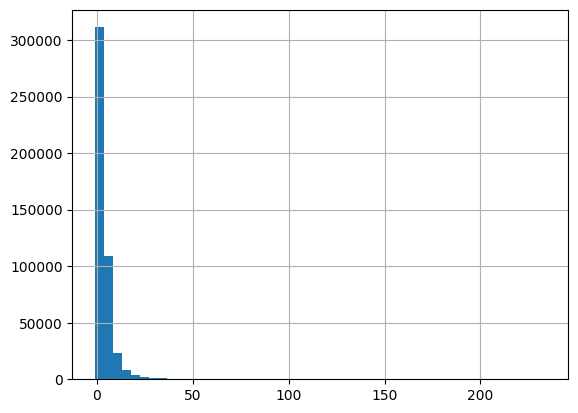

In [15]:
df_nonicu["hosp_los"].hist(bins=50)

**Descriptive Summary**

The distribution of hospital length of stay (LOS) was highly right-skewed. Most non-ICU admissions had short hospitalizations clustered around a few days, while a small number of admissions showed markedly longer lengths of stay,　with the right tail extending well beyond the main mass of the distribution.

This distribution is consistent with expected hospitalization patterns in a general non-ICU adult population and confirms the presence of long-stay outliers.

### 4.8 Verify Non-ICU Cohort Has Zero ICU Admissions

In [16]:
# This should always be zero
query_icu_check = f"""
SELECT COUNT(*) AS n_icu
FROM `{TABLE_NONICU}` n
JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
  ON n.subject_id = i.subject_id
 AND n.hadm_id   = i.hadm_id
"""
client.query(query_icu_check).to_dataframe()

,n_icu
0,0


**Descriptive Summary**

The overlap count between the non-ICU admissions table and ICU stays was zero, confirming that ICU-associated admissions were successfully excluded from the cohort.

### 4.9 Cohort Size and Key Demographic Summary

In [17]:
print("n_base_admissions:", df_base.shape[0])
print("n_nonicu_admissions:", df_nonicu.shape[0])
print(f"mortality_rate: {df_nonicu['hospital_expire_flag'].mean()*100:.5f} %")
print("median_age:", df_nonicu["age"].median())

n_base_admissions: 546028
n_nonicu_admissions: 460786
mortality_rate: 0.50479 %
median_age: 60.0


**Descriptive Summary**

The base adult admissions cohort consisted of 546,028 hospital admissions, of which 460,786 (84.4%) remained after excluding admissions with any ICU stay.

Within the non-ICU cohort, the in-hospital mortality rate was 0.50%, reflecting a relatively low short-term mortality burden in this population.

The median age at admission was 60 years, indicating a predominantly middle-aged to older adult cohort.

## 5. Outputs and Downstream Use

This notebook constructs foundational hospital admission–level cohort tables in BigQuery that serve as upstream inputs for all subsequent exposure definition and analysis steps.

**Outputs**

As a result of executing the SQL scripts in this notebook, the following tables are materialized in the
mimic-iv-portfolio.nonicu_raas dataset:

- **base_admissions**
An adult hospital admissions table derived from MIMIC-IV v3.1, containing one row per hospital admission.
This table includes admission timing, demographic variables, insurance and admission metadata, an approximate age at admission derived from anchor variables, and hospital length of stay. It serves as the upstream input for race category collapsing and subsequent cohort refinement steps, including `01_collapse_race_categories.sql`.

- **base_admissions_racegrp**
An intermediate derived table created by collapsing raw race categories into predefined race groups (e.g., White, Black, Hispanic, Asian, Other).
This table is used as an input to the ICU-exclusion step (`02_exclude_icu_admissions.sql`) to ensure consistent race categorization prior to construction of the final non-ICU cohort.

- **nonicu_admissions** 
A refined admission-level cohort created by excluding all hospital admissions with any recorded ICU stay.
Each row represents a single adult, non-ICU hospital admission, uniquely identified by (subject_id, hadm_id).

These tables are constructed entirely via SQL and represent finalized cohort-selection outputs of the data preparation pipeline.

**Downstream Use**

The nonicu_admissions table serves as the core cohort input for downstream notebooks, including:

- Early RAAS inhibitor exposure definition (02)
- Construction of the unified analysis dataset (03a)
- Baseline characteristic summaries (03b)
- Unadjusted outcome summaries and crude analyses (04a)
- Multivariable and adjusted outcome modeling with demographic covariates (04b)

Downstream notebooks load these tables in read-only mode and do not modify cohort inclusion criteria.
This design ensures a clear separation between cohort construction, exposure definition, and analytic modeling, supporting reproducibility and transparent data provenance.

Together, these tables define a transparent, stepwise cohort construction pipeline that separates raw data ingestion, demographic preprocessing, and cohort restriction.